# Upgrade the safe point generator

Upgrades made:

- Omitted tracked objects from segmented image, so that matching with offline image is better


### Load the segmentation model


In [1]:
import sys

sys.path.append(
    "/home/emilia/msc_ros2/master_ws/src/msc_thesis/water_segmentation/water_segmentation/"
)
from water_segmentation.Pytorch_segmentation.segnet import *
from water_segmentation.Pytorch_segmentation.predict import *
from water_segmentation.lib.map_segmentation_utils import *

import torch
from PIL import Image
import segmentation_models_pytorch as smp

# model = SegNet_model.SegNet(n_channels=3, n_classes=1)

checkpoint = torch.load(
    "/home/emilia/WaterSegNet/checkpoints/model-Unetplusplus_adam_b16_e20.ckpt"
)
state_dict = checkpoint["state_dict"]

model = smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=3,
    classes=1,
    activation=None,
)
# model = SegNet_model.SegNet(n_channels=3, n_classes=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.load_state_dict(state_dict)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

# state_dict = torch.load(
#     "/home/emilia/msc_ros2/ML/checkpoints/SegNet_rmsprop.pt", map_location=device
# )
# mask_values = state_dict.pop("mask_values", [0, 1])
# model.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

### Apply segmentation to an image


In [6]:
import supervision as sv
from matplotlib import pyplot as plt
from PIL import ImageOps, Image
import numpy as np

SOURCE_IMAGE_PATH = "/home/emilia/msc_ros2/ML/src/Segmentation/test/trondheim.jpg"

image_raw = Image.open(SOURCE_IMAGE_PATH)

image = Image.fromarray(np.uint8(image_raw)).convert("RGB")


def center_crop(image, new_width, new_height):
    width, height = image.size
    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2

    image = image.crop((left, top, right, bottom))
    return image


pil_img = image.copy()
w, h = pil_img.size
target_size = 256
max_side = max(w, h)
pad_w, pad_h = max_side - w, max_side - h
padding = (pad_w // 2, pad_h // 2, pad_w - pad_w // 2, pad_h - pad_h // 2)
cropped_img = center_crop(pil_img, min(w, h), min(w, h))
# pil_img = ImageOps.expand(pil_img, padding)
pil_img = cropped_img.resize((target_size, target_size), resample=Image.BICUBIC)

mask = predict_img(net=model, full_img=image_raw, out_threshold=0.5, device=device)
mask_image = mask_to_image(mask, mask_values)
# overlay_image = apply_mask_overlay(np.asarray(image_raw), mask_image)

# sv.plot_image(image=image, size=(8, 8))
# sv.plot_image(image=mask_image, size=(8, 8))
plt.imshow(image_raw)
plt.show()
plt.imshow(pil_img)

/tmp/ipykernel_51560/3250449044.py:32: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  pil_img = cropped_img.resize((target_size, target_size), resample=Image.BICUBIC)


AttributeError: 'YOLO' object has no attribute 'eval'. See valid attributes below.

    YOLO (You Only Look Once) object detection model.

    Args:
        model (str, Path): Path to the model file to load or create.
        task (Any, optional): Task type for the YOLO model. Defaults to None.

    Attributes:
        predictor (Any): The predictor object.
        model (Any): The model object.
        trainer (Any): The trainer object.
        task (str): The type of model task.
        ckpt (Any): The checkpoint object if the model loaded from *.pt file.
        cfg (str): The model configuration if loaded from *.yaml file.
        ckpt_path (str): The checkpoint file path.
        overrides (dict): Overrides for the trainer object.
        metrics (Any): The data for metrics.

    Methods:
        __call__(source=None, stream=False, **kwargs):
            Alias for the predict method.
        _new(cfg:str, verbose:bool=True) -> None:
            Initializes a new model and infers the task type from the model definitions.
        _load(weights:str, task:str='') -> None:
            Initializes a new model and infers the task type from the model head.
        _check_is_pytorch_model() -> None:
            Raises TypeError if the model is not a PyTorch model.
        reset() -> None:
            Resets the model modules.
        info(verbose:bool=False) -> None:
            Logs the model info.
        fuse() -> None:
            Fuses the model for faster inference.
        predict(source=None, stream=False, **kwargs) -> List[ultralytics.yolo.engine.results.Results]:
            Performs prediction using the YOLO model.

    Returns:
        list(ultralytics.yolo.engine.results.Results): The prediction results.
    

### Load Detection model



0: 864x1280 4 floating-objects, 35.4ms
Speed: 10.4ms preprocess, 35.4ms inference, 7.2ms postprocess per image at shape (1, 3, 1280, 1280)


Detections:  Detections(xyxy=array([[     3142.7,      2526.3,      3281.1,      2657.4],
       [     1533.6,      2155.2,      1596.1,      2240.2],
       [     1069.8,      2467.3,      1219.7,      2633.8],
       [     1124.2,      792.95,      1219.9,      926.97]], dtype=float32), mask=None, confidence=array([    0.65858,     0.62924,     0.60306,     0.53769], dtype=float32), class_id=array([1, 1, 1, 1]), tracker_id=None)


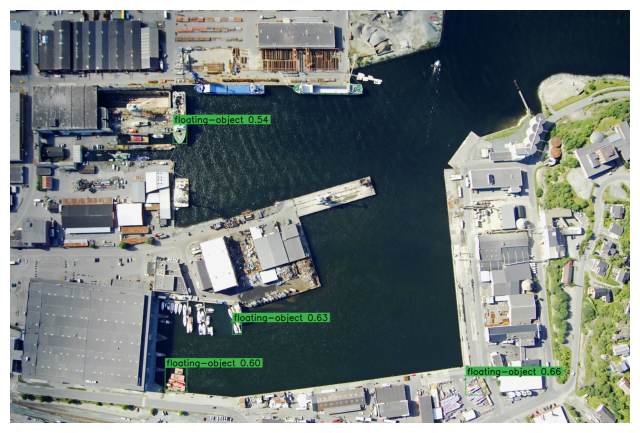

In [3]:
from ultralytics import YOLO

model = YOLO("/home/emilia/msc_ros2/ML/checkpoints/search_nano_model.pt")
annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
cv2_image = cv2.imread(SOURCE_IMAGE_PATH)
result = model.predict(cv2_image, conf=0.5)[0]

detections = sv.Detections.from_ultralytics(result)

# filtered_detections = [det for det in detections if det[2] > 0.5]

print("Detections: ", detections)
labels = [
    f"{model.model.names[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _ in detections
]

processed_img = annotator.annotate(
    scene=cv2_image, detections=detections, labels=labels
)

sv.plot_image(image=processed_img, size=(8, 8))

### Removing bounding boxes from segmented image


In [4]:
import numpy as np


def bbox_to_mask(detections, mask_image, padding_factor=0.2):
    """
    Takes a list of detections and a mask image and returns a mask with the bounding boxes
    """
    floating_obj_mask = np.ones(mask_image.shape[:2], dtype=np.uint8) * 255
    human_mask = np.ones(mask_image.shape[:2], dtype=np.uint8) * 255

    for bbox, _, _, class_id, _ in detections:
        bbox = bbox.astype(int)
        width = bbox[2] - bbox[0]
        height = bbox[3] - bbox[1]

        # Calculate padding
        pad_x = int(width * padding_factor)
        pad_y = int(height * padding_factor)

        # Apply padding
        padded_bbox = [
            bbox[0] - pad_x,
            bbox[1] - pad_y,
            bbox[2] + pad_x,
            bbox[3] + pad_y,
        ]

        # bbox_mask[padded_bbox[1] : padded_bbox[3], padded_bbox[0] : padded_bbox[2]] = 0
        if class_id == 1:
            floating_obj_mask[
                padded_bbox[1] : padded_bbox[3], padded_bbox[0] : padded_bbox[2]
            ] = 0
        elif class_id == 0:
            human_mask[
                padded_bbox[1] : padded_bbox[3], padded_bbox[0] : padded_bbox[2]
            ] = 0

    # mask_with_bbox = bbox_mask * mask_image.astype(np.uint8)
    return floating_obj_mask, human_mask


floating_obj_mask, human_mask = bbox_to_mask(detections, mask_image)
bbox_mask = floating_obj_mask * human_mask  # Use this with offline map for matching

NameError: name 'mask_image' is not defined

### Code for finding the closest safe point


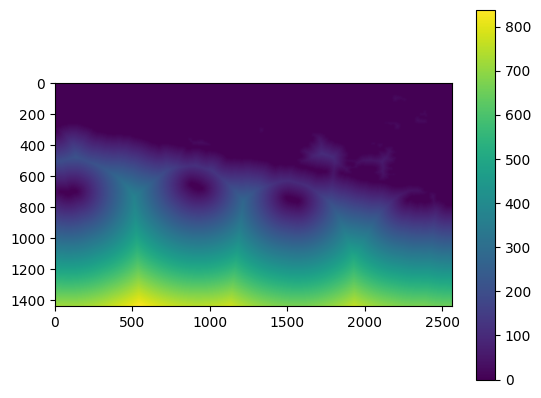

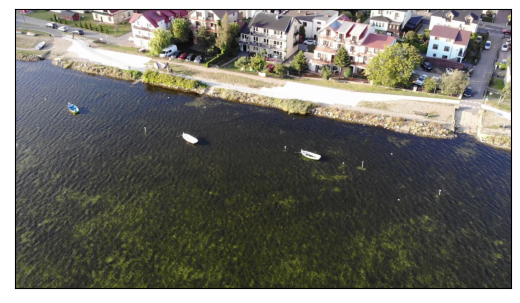

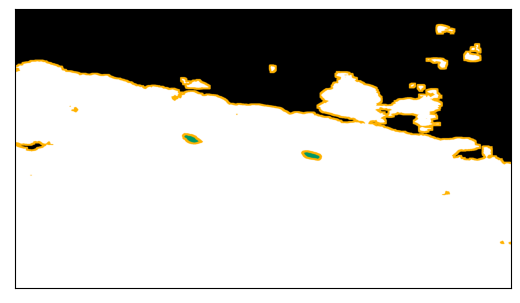

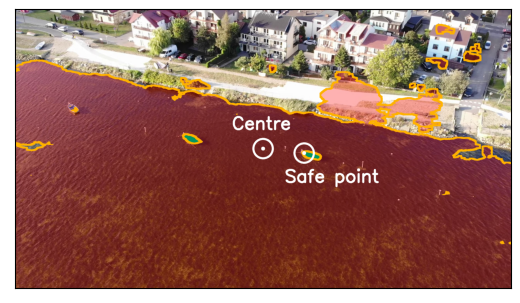

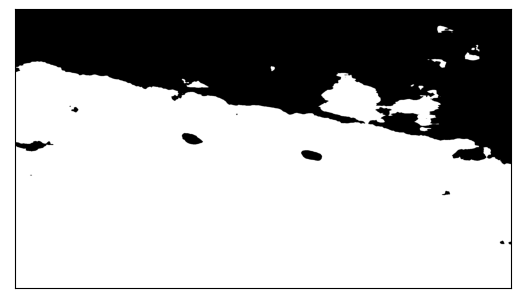

In [28]:
import cv2
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt


def find_closest_safe_point(mask_image, coords=None):
    """
    Calculate distance map and find closest safe point to centre.
    """
    binary_mask = (mask_image / 255).astype(np.uint8)
    distance_map, indices = ndimage.distance_transform_edt(
        binary_mask, return_indices=True
    )

    if coords is None:
        center_coords = np.array(binary_mask.shape) // 2
        coords = center_coords

    distance_at_coords = distance_map[coords[0], coords[1]]
    indices_at_coords = indices[:, coords[0], coords[1]]
    plt.imshow(distance_map)
    plt.colorbar()
    plt.show()

    return indices_at_coords[1], indices_at_coords[0]


def draw_processed_mask(mask_image, padded_water, closest_point, dynamic_points):
    """
    Visualize the processed mask.
    """
    mask_rgb = cv2.cvtColor(mask_image, cv2.COLOR_GRAY2RGB)

    water_padding_color = (255, 178, 0)
    dynamic_color = (0, 150, 100)
    point_color = (0, 50, 200)

    center = mask_image.shape[1] // 2, mask_image.shape[0] // 2
    padded_area = padded_water > mask_image

    mask_rgb[dynamic_points] = dynamic_color
    mask_rgb[padded_area] = water_padding_color
    # cv2.circle(mask_rgb, center, radius=20, color=point_color, thickness=-1)
    # cv2.circle(mask_rgb, closest_point, radius=20, color=point_color, thickness=-1)

    return mask_rgb


def show_results(image, raw_mask, safe_mask, shaded_image):
    """
    Show the results of the segmentation.
    """
    fig, ax = plt.subplots(2, 2, figsize=(20, 10))
    ax[0, 0].imshow(image)
    ax[0, 0].set_title("Original Image")

    ax[0, 1].imshow(raw_mask, cmap="gray")
    ax[0, 1].set_title("Mask before processing")

    ax[1, 0].imshow(safe_mask)
    ax[1, 0].set_title("Mask after processing")

    ax[1, 1].imshow(shaded_image)
    ax[1, 1].set_title("Shaded image")

    plt.show()


def apply_padding(mask_image, padding_factor):
    """
    Apply padding to the mask around the water.
    """
    kernel = np.ones((padding_factor, padding_factor), np.uint8)
    padded_mask = cv2.dilate(mask_image, kernel, iterations=1)
    return padded_mask


def apply_mask_shade(image, mask_image, padded_mask, closest_point, dynamic_points):
    """
    Apply overlay of water to the mask.
    Apply padded colour area to the mask.
    Add a circle to the center of the mask and the closest safe point.

    """
    image = np.asarray(image)

    water_color = (255, 0, 0)
    water_padding_color = (255, 178, 0)
    dynamic_color = (0, 150, 100)
    point_color = (255, 255, 255)
    color_overlay = np.full_like(image, water_color, dtype=np.uint8)

    alpha = 0.3
    mask_area = mask_image == 255
    blended_image = np.where(
        mask_area[..., None],  # Expand dimensions for broadcasting
        cv2.addWeighted(image, 1 - alpha, color_overlay, alpha, 0),
        image,
    )

    padded_area = padded_mask > mask_image
    blended_image[dynamic_points] = dynamic_color
    blended_image[padded_area] = water_padding_color
    center = mask_image.shape[1] // 2, mask_image.shape[0] // 2

    cv2.circle(blended_image, center, radius=10, color=(255, 255, 255), thickness=-1)
    cv2.circle(blended_image, center, radius=50, color=(255, 255, 255), thickness=10)
    cv2.circle(blended_image, closest_point, radius=10, color=point_color, thickness=-1)
    cv2.circle(blended_image, closest_point, radius=50, color=point_color, thickness=10)

    cv2.putText(
        blended_image,
        "Centre",
        (center[0] - 160, center[1] - 100),
        cv2.FONT_HERSHEY_SIMPLEX,
        3,
        (255, 255, 255),
        10,
    )
    cv2.putText(
        blended_image,
        "Safe point",
        (closest_point[0] - 100, closest_point[1] + 150),
        cv2.FONT_HERSHEY_SIMPLEX,
        3,
        point_color,
        10,
    )

    return blended_image


def define_safe_mask(detections, mask_image, use_dynamic_points=False):
    floating_obj_mask, human_mask = bbox_to_mask(detections, mask_image)
    safe_mask = mask_image.copy()
    human_points = (mask_image == 0) & (human_mask == 0)
    safe_mask[human_points] = 255
    dynamic_points = (mask_image == 0) & (floating_obj_mask == 0)

    if not use_dynamic_points:
        safe_mask[dynamic_points] = 255

    return safe_mask, dynamic_points


safe_mask, dynamic_points = define_safe_mask(
    detections, mask_image, use_dynamic_points=True
)
padded_mask = apply_padding(safe_mask, 20)

closest_point = find_closest_safe_point(padded_mask)


processed_mask = draw_processed_mask(
    safe_mask, padded_mask, closest_point, dynamic_points
)
shaded_image = apply_mask_shade(
    image_raw, safe_mask, padded_mask, closest_point, dynamic_points
)
# show_results(image_raw, np.asarray(mask_image), processed_mask, shaded_image)


images = [image_raw, processed_mask, shaded_image]
for i in images:
    fig = plt.imshow(i)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.show()

fig = plt.imshow(mask_image, cmap="gray")
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.show()

### Window Sliding Method

Can see that if striding is small, the computation time is large. My method allows to check all pixels, with very low computation time.


In [15]:
from skimage.util import view_as_windows


def find_safe_areas(image: np.ndarray, window_size: int, stride: int) -> np.ndarray:
    # Define a sliding window of size window_size
    window = np.ones((window_size, window_size), dtype=np.uint8)

    binary_img = np.where(image > 0, 0, 1)  # Invert image and make binary
    center = np.array(binary_img.shape) / 2

    # Crop a subarray centered at the image center and of size window_size times window_size
    center_window = binary_img[
        int(center[0] - window_size / 2) : int(center[0] + window_size / 2),
        int(center[1] - window_size / 2) : int(center[1] + window_size / 2),
    ]

    # Check if the center window is safe
    if np.sum(np.multiply(center_window, window)) == window_size**2:
        return np.array(center)

    # Split the binary image into windows
    windows = view_as_windows(binary_img, window.shape, step=stride)

    safe_loc = []
    for i in range(len(windows)):
        for j in range(len(windows[i])):
            res = np.multiply(windows[i, j], window)
            if np.sum(res) == window_size**2:
                safe_loc.append(
                    [
                        (i * stride) + (window_size // 2),
                        (j * stride) + (window_size // 2),
                    ]
                )

    safe_loc = np.array(safe_loc)

    if len(safe_loc) != 0:
        distances = np.linalg.norm(safe_loc - center, axis=1)
        min_index = np.argmin(distances)
        closest_safe_window = safe_loc[min_index]
        return closest_safe_window
    else:
        return [None]


find_safe_areas(mask_image, 40, 2)

array([ 482, 1300])